
<h2 align=center> Named Entity Recognition (NER) using LSTMs with Keras</h2>

### Task 1: Project Overview and Import Modules

In [33]:
import warnings
warnings.filterwarnings('ignore')

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
plt.style.use("ggplot")

import tensorflow as tf
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.10.1
GPU detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Task 2: Load and Explore the NER Dataset

*Essential info about tagged entities*:
- geo = Geographical Entity
- org = Organization
- per = Person
- gpe = Geopolitical Entity
- tim = Time indicator
- art = Artifact
- eve = Event
- nat = Natural Phenomenon

In [5]:
data = pd.read_csv("ner_datasetreference.csv", encoding="latin1")
data = data.fillna(method="ffill")
data.head(10)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [6]:
print("Unique words in corpus:", data['Word'].nunique())
print("Unique tags in corpus:", data['Tag'].nunique())

Unique words in corpus: 35177
Unique tags in corpus: 17


In [8]:
words = list(set(data["Word"].values))
words.append("ENDPAD")
num_words = len(words)
print(num_words)

35178


In [9]:
tags = list(set(data["Tag"].values))
num_tags = len(tags)
print(num_tags)

17


### Task 3: Retrieve Sentences and Corresponsing Tags

In [10]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [12]:
### Each sentences each word belongs to one POS tag
getter = SentenceGetter(data)
sentences = getter.sentences

In [13]:
## for the first sentence
sentences[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

### Task 4: Define Mappings between Sentences and Tags

In [14]:
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [22]:
### sample word2idx
list(word2idx.items())[:5]

[('immigrate', 1), ('converged', 2), ('Gedi', 3), ('Net', 4), ('132', 5)]

In [23]:
### sample tag2idx
list(tag2idx.items())[:5]

[('B-nat', 0), ('I-tim', 1), ('I-eve', 2), ('B-org', 3), ('B-gpe', 4)]

### Task 5: Padding Input Sentences and Creating Train/Test Splits

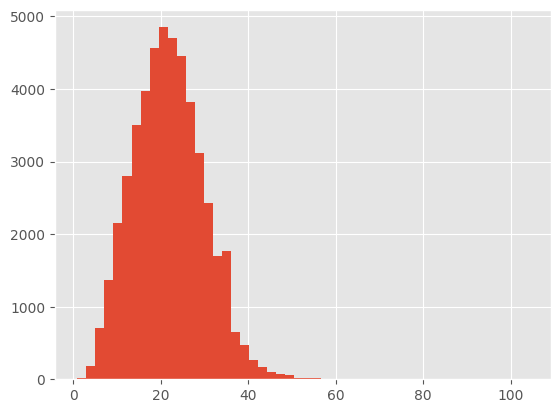

In [26]:
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [27]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = 50 ## maximum length of a sequence can be of 50 characters

X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=num_words-1)

y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

In [28]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

### Task 6: Build and Compile a Bidirectional LSTM Model

In [39]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [38]:
def createModel(input_shape,num_words,num_tags):
    input_word = Input(shape=(input_shape,))
    model = Embedding(input_dim=num_words, output_dim=50, input_length=input_shape)(input_word)
    model = SpatialDropout1D(0.1)(model)
    model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
    out =   TimeDistributed(Dense(num_tags, activation="softmax"))(model)
    model = Model(input_word, out)
    return model

model = createModel(max_len,num_words,num_tags)
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding_3 (Embedding)     (None, 50, 50)            1758900   
                                                                 
 spatial_dropout1d_3 (Spatia  (None, 50, 50)           0         
 lDropout1D)                                                     
                                                                 
 bidirectional_3 (Bidirectio  (None, 50, 200)          120800    
 nal)                                                            
                                                                 
 time_distributed_3 (TimeDis  (None, 50, 17)           3417      
 tributed)                                                       
                                                           

In [35]:
## Compile the model
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

### Task 7: Train the Model

In [37]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

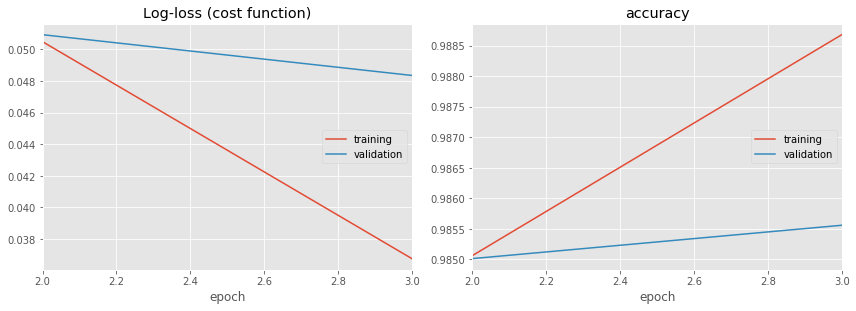

Log-loss (cost function):
training   (min:    0.037, max:    0.181, cur:    0.037)
validation (min:    0.048, max:    0.066, cur:    0.048)

accuracy:
training   (min:    0.958, max:    0.989, cur:    0.989)
validation (min:    0.981, max:    0.986, cur:    0.986)

Epoch 00003: val_loss improved from 0.05093 to 0.04835, saving model to model_weights.h5
38367/38367 [==============================] - 228s 6ms/sample - loss: 0.0368 - accuracy: 0.9887 - val_loss: 0.0484 - val_accuracy: 0.9856
CPU times: user 15min 48s, sys: 27.2 s, total: 16min 15s
Wall time: 11min 41s


In [ ]:
%%time

chkpt = ModelCheckpoint("model_weights.h5", monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=True, mode='min')

early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=1, verbose=0, mode='max', baseline=None, restore_best_weights=False)

callbacks = [PlotLossesCallback(), chkpt, early_stopping]

history = model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_test,y_test),
    batch_size=32,
    epochs=3,
    callbacks=callbacks,
    verbose=1
)

### Task 8: Evaluate Named Entity Recognition Model

In [ ]:
model.evaluate(x_test, y_test)

9592/9592 [==============================] - 12s 1ms/sample - loss: 0.0484 - accuracy: 0.9856


[0.04835232572507321, 0.9855588]

In [ ]:
i = np.random.randint(0, x_test.shape[0]) #659
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)
y_true = y_test[i]
print("{:15}{:5}\t {}\n".format("Word", "True", "Pred"))
print("-" *30)
for w, true, pred in zip(x_test[i], y_true, p[0]):
    print("{:15}{}\t{}".format(words[w-1], tags[true], tags[pred]))

Word           True 	 Pred

------------------------------
The            O	O
United         B-org	B-org
Nations        I-org	I-org
has            O	O
been           O	O
under          O	O
fire           O	O
for            O	O
failing        O	O
to             O	O
stop           O	O
ongoing        O	O
ethnic         O	O
violence       O	O
in             O	O
Ituri          B-geo	B-geo
.              O	O
Surrey         O	O
Surrey         O	O
Surrey         O	O
Surrey         O	O
Surrey         O	O
Surrey         O	O
Surrey         O	O
Surrey         O	O
Surrey         O	O
Surrey         O	O
Surrey         O	O
Surrey         O	O
Surrey         O	O
Surrey         O	O
Surrey         O	O
Surrey         O	O
Surrey         O	O
Surrey         O	O
Surrey         O	O
Surrey         O	O
Surrey         O	O
Surrey         O	O
Surrey         O	O
Surrey         O	O
Surrey         O	O
Surrey         O	O
Surrey         O	O
Surrey         O	O
Surrey         O	O
Surrey         O	O
Surrey         O	O
Surre